In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

In [3]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

In [4]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1])) # confidence metric c, dont transform that
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) #.circle creates circle, 4 is size, 255 is color green, -1 is fill circle

In [5]:
"""EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}"""
EDGES = {
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [6]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

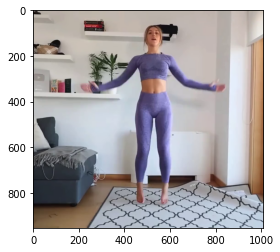

In [25]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
capvid.release()

In [27]:
capvid.read()

(True,
 array([[[170, 172, 179],
         [170, 172, 179],
         [171, 173, 180],
         ...,
         [191, 203, 215],
         [192, 204, 216],
         [193, 205, 217]],
 
        [[170, 172, 179],
         [170, 172, 179],
         [169, 171, 178],
         ...,
         [192, 204, 216],
         [192, 204, 216],
         [193, 205, 217]],
 
        [[170, 172, 179],
         [171, 173, 180],
         [170, 172, 179],
         ...,
         [192, 204, 216],
         [192, 204, 216],
         [193, 205, 217]],
 
        ...,
 
        [[ 65,  90, 116],
         [ 65,  90, 116],
         [ 65,  90, 116],
         ...,
         [224, 205, 192],
         [226, 208, 193],
         [226, 208, 193]],
 
        [[ 64,  89, 115],
         [ 64,  89, 115],
         [ 64,  89, 115],
         ...,
         [226, 207, 194],
         [227, 209, 194],
         [227, 209, 194]],
 
        [[ 64,  89, 115],
         [ 64,  89, 115],
         [ 64,  89, 115],
         ...,
         [226, 207, 1

In [7]:
def add_keypoints_videos(video):
    capvid = cv2.VideoCapture(os.path.join('videos',video))
    for frame_idx in range(int(capvid.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = capvid.read()

        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis = 0), 192, 192)
        input_image = tf.cast(img, dtype=tf.float32)

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

        draw_connections(frame, keypoints_with_scores, EDGES, 0.6)
        draw_keypoints(frame, keypoints_with_scores[0][0][5:], 0.6)

        cv2.imshow("Movenet Lightning", frame)

        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    capvid.release()
    cv2.destroyAllWindows()
    return keypoints_with_scores[0][0][5:]

In [56]:
scores_vid = add_keypoints_videos('jumpingjacks.mp4')

In [13]:
scores_vid[0]

NameError: name 'scores_vid' is not defined

In [8]:
def add_keypoints_live():
    cap = cv2.VideoCapture(0)
    
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')

    fps = 13
    video_writer = cv2.VideoWriter(os.path.join('videos','outputs','IshaJumpJacks.mp4'), fourcc, fps,(int(cap.get(3)),int(cap.get(4))))
    
    if not video_writer.isOpened():
        print("Error opening video writer")
    
    while cap.isOpened():
        ret, frame = cap.read()

        # reshape image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis = 0), 192, 192)
        input_image = tf.cast(img, dtype=tf.float32)

        # setup input and output
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # make predictions
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        # print(keypoints_with_scores)

        # rendering
        draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
        draw_keypoints(frame, keypoints_with_scores[0][0][5:], 0.4)

        # Write out frame 
        video_writer.write(frame)
        
        cv2.imshow("Movenet Lightning", frame)

        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    video_writer.release()
    return keypoints_with_scores[0][0][5:]

In [27]:
scores_live = add_keypoints_live()

In [61]:
scores_live

array([[0.15899408, 0.84586763, 0.08926702],
       [0.19849029, 0.51655054, 0.12616555],
       [0.46334898, 0.8534164 , 0.12199292],
       [0.52352285, 0.6139361 , 0.33129796],
       [0.7044758 , 0.7757119 , 0.20747213],
       [0.7508433 , 0.7167847 , 0.11394679],
       [0.4503398 , 0.777534  , 0.20299561],
       [0.46296033, 0.5524099 , 0.14272848],
       [0.775917  , 0.7556119 , 0.27336502],
       [0.77738756, 0.6981093 , 0.18225618],
       [0.7569808 , 0.7405523 , 0.09483103],
       [0.75711006, 0.7259745 , 0.09534486]], dtype=float32)

In [9]:
def display_two_vids(video1, video2):
    cap1 = cv2.VideoCapture(os.path.join('videos',video1))
    cap2 = cv2.VideoCapture(os.path.join('videos',video2))
    
    while True:
        ret1, frame1 = cap1.read()

        while ret1:
            cv2.imshow("Video Player", frame1)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            ret1, frame1 = cap1.read()

        if not ret1 and cap2.isOpened():
            while True:
                ret2, frame2 = cap2.read()

                while ret2:
                    cv2.imshow("Video Player", frame2)
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
                    ret2, frame2 = cap2.read()
                break_True = True
                break
        if break_True:
            break
        if not ret1 and not cap2.isOpened():
            break
    
    # Close down everything
    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()

In [7]:
# workout
# play 10 second timer
# play workout video
# follow along
# show similarity score in a popup next to it
# save similarity score and live video
# point out mistakes and differences

def workout():
    # cap1 = cv2.VideoCapture(os.path.join('videos','10secCountdown.mp4'))
    # cap2 = cv2.VideoCapture(os.path.join('videos','jumpingjacks.mp4'))
    all_frames_vid1 = frame_array('10secCountdown.mp4')
    all_frames_vid2 = frame_array('cutjumpjacks360.mp4')
    for frame1 in all_frames_vid1:
        cv2.imshow("Video Player", frame1)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap_live = cv2.VideoCapture(0)
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = cap_live.get(cv2.CAP_PROP_FPS)
    video_writer = cv2.VideoWriter(os.path.join('videos','outputs','IshaJumpJacks.mp4'), 
                                    fourcc, fps, (360, 640)) #(int(cap_live.get(3)),int(cap_live.get(4)))) 
    # live_frames = [0] * len(all_frames_vid2)
    for frame_idx, frame2 in enumerate(all_frames_vid2):
        cv2.imshow('Video Player', frame2)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        ret_live, frame_live = cap_live.read()
        # live_frames[frame_idx] = frame_live
        video_writer.write(frame_live)    
    #cap_live.release()
    cv2.destroyAllWindows()
    return


In [8]:
fps = workout()
print(fps)

KeyboardInterrupt: 

In [8]:
                """
                img = frame_live.copy()
                img = tf.image.resize_with_pad(tf.expand_dims(img, axis = 0), 192, 192)
                input_image = tf.cast(img, dtype=tf.float32)

                input_details = interpreter.get_input_details()
                output_details = interpreter.get_output_details()

                interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
                interpreter.invoke()
                keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

                draw_connections(frame_live, keypoints_with_scores, EDGES, 0.4)
                draw_keypoints(frame_live, keypoints_with_scores[0][0][5:], 0.4)
                """

"\nimg = frame_live.copy()\nimg = tf.image.resize_with_pad(tf.expand_dims(img, axis = 0), 192, 192)\ninput_image = tf.cast(img, dtype=tf.float32)\n\ninput_details = interpreter.get_input_details()\noutput_details = interpreter.get_output_details()\n\ninterpreter.set_tensor(input_details[0]['index'], np.array(input_image))\ninterpreter.invoke()\nkeypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])\n\ndraw_connections(frame_live, keypoints_with_scores, EDGES, 0.4)\ndraw_keypoints(frame_live, keypoints_with_scores[0][0][5:], 0.4)\n"

In [10]:
def merge_two_videos(video1, video2):
    cap1 = cv2.VideoCapture(video1)
    cap2 = cv2.VideoCapture(video2)
    
    frame_width = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(cap1.get(cv2.CAP_PROP_FPS))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('output.mp4', fourcc, frame_rate, (frame_width * 2, frame_height))
    
    while True:
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()
        if not ret1 or not ret2:
            break
        frame2 = cv2.resize(frame2, (frame_width, frame_height))
        canvas = np.zeros((frame_height, frame_width * 2, 3), dtype = np.uint8)
        canvas[:, :frame_width] = frame1
        canvas[:, frame_width:] = frame2
        out.write(canvas)
    cap1.release()
    cap2.release()
    cv2.destroyAllWindows()
    return

In [11]:
merge_two_videos(os.path.join('videos', "jjack.mp4"), os.path.join('videos', "jumpingjacks.mp4"))

In [11]:
def frame_array(video):
    all_frames = []
    cap = cv2.VideoCapture(os.path.join('videos',video))
    for frame_idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        """try:
            frame = cv2.resize(frame, (200,200))
        except:
            break"""
        all_frames.append(frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Close down everything
    cap.release()
    cv2.destroyAllWindows()
    return all_frames

In [12]:
all_frames, fps = frame_array("cutjumpjacks360.mp4")
print(fps)
for frame in all_frames:
    cv2.imshow('Video Player', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

23.97463696627043


In [15]:
for frame in liv:
    try:
        frame = cv2.resize(frame, (505,477))
    except:
        break
    cv2.imshow('Video Player', frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [38]:
def test():
    cap_vid1 = cv2.VideoCapture(os.path.join("videos", "cutjumpjacks360.mp4"))

    cap_live = cv2.VideoCapture(0)

    while True:
        # Read frame from countdown video
        ret_vid1, frame1 = cap_vid1.read()
        if not ret_vid1:
            break

        # Resize frame (optional)
        frame1 = cv2.resize(frame1, (200, 200))

        # Read frame from live webcam
        ret_live, frame_live = cap_live.read()
        if not ret_live:
            break

        # Display both frames
        cv2.imshow("Video Player 1", frame1)

        # Check for quit key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

      # Release resources
    cap_vid1.release()
    cap_live.release()
    cv2.destroyAllWindows()

In [39]:
test()